In [1]:
# import
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt


from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier

%matplotlib inline

In [2]:
mnist = fetch_mldata('MNIST original')

In [3]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
print(X.shape, y.shape)

(70000, 784) (70000,)


#### display an image

In [6]:
some_digits = X[36001]
some_digits_img = some_digits.reshape(28, 28)

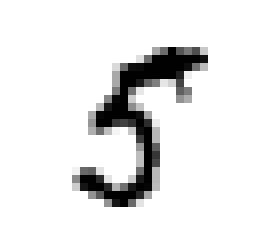

In [7]:
plt.imshow(some_digits_img, cmap=matplotlib.cm.binary, interpolation='Nearest')
plt.axis("off")
plt.show()

In [8]:
### checking out its label
y[36001]

5.0

In [9]:
# MNIST dataset is already split into train(first 60000) and test(last 10000) 
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

# let's suffle these train set to avoid any bias for algo
suffled_indices = np.random.permutation(60000)
X_train, y_train = X_train[suffled_indices], y_train[suffled_indices]

### Let's try to train a BINARY classification

In [10]:
# converting the target into binary info, Foy 5
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

 A good place to start is with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning)

In [11]:
sgd_clf = SGDClassifier(random_state=142)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=142, shuffle=True,
       verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digits])

array([ True], dtype=bool)

### Measuring the Accuracy  
1. By Stratified Splitted data

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

In [14]:
skfolds = StratifiedShuffleSplit(n_splits=5, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # creating classified object
    clone_clf = SGDClassifier(random_state=42)
    # splitting the data into train n test
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    # fitting the data
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    
    print(np.mean(y_pred==y_test_folds), end='   ')

0.961   0.960333333333   0.9395   0.964166666667   0.967   

2. Now using CV

In [15]:
from sklearn.model_selection import cross_val_score

In [16]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([ 0.97075244,  0.76716667,  0.89841667,  0.96783333,  0.96141345])

As we can see accuract is above 90% in all cases, it seems weird, let's check the base estimate

In [17]:
from sklearn.base import BaseEstimator

In [18]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([ 0.90733333,  0.90941667,  0.907     ,  0.9125    ,  0.912     ])

base classifier gives 90% accuracy bacause our data is skewed towards "Not 5" category

In [20]:
# being a image is 5 accuracy
print(np.mean(y_train_5))  # which means not 5 is
print(1-np.mean(y_train_5))

0.09035
0.90965


### Confusion Matrix

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred_5 = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)
confusion_matrix(y_train_5, y_pred_5)

array([[50127,  4452],
       [  761,  4660]])

### Precision and Recall  

### $ precision = \frac{TP}{TP+FP} $  
### $ recall = \frac{TP}{TP+FN} $

In [22]:
from sklearn.metrics import precision_score, recall_score

print("precision score: ", precision_score(y_train_5, y_pred_5))
print("recall score: ", recall_score(y_train_5, y_pred_5))

precision score:  0.511413520632
recall score:  0.859619996311


### F1 Score  

It is often convenient to combine precision and recall into a single metric called the F1 score, in
particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of
precision and recall.  
Whereas the regular mean treats all values equally, the harmonic
mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if
both recall and precision are high.

## $ f1-score =  \frac{2}{\frac{1}{precision} + \frac{1}{recall}}  =  \frac{2 * precision * recall}{precision + recall} $  

The F1 score favors classifiers that have similar precision and recall. This is not always what you want:
in some contexts you mostly care about precision, and in other contexts you really care about recall.

In [23]:
from sklearn.metrics import f1_score
print("f1-score: ", f1_score(y_train_5, y_pred_5))

f1-score:  0.641299112365


There is always a trade off between precision and recall and it denepeds on the threshold value which help to decide whether it is a positive value or negative. Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores
that it uses to make predictions. Instead of calling the classifier’s predict() method, you can call its
decision_function() method, which returns a score for each instance, and then make predictions based
on those scores using any threshold you want

In [24]:
y_score = sgd_clf.decision_function([some_digits])
y_score

array([ 8732.17804489])

In [26]:
threshold = 0 
y_pred = (y_score>threshold)
y_pred

array([ True], dtype=bool)

In [36]:
# let's increase the threshold 
threshold = 200000
y_pred = (y_score>threshold)
y_pred

array([False], dtype=bool)

In [37]:
# as we increase the threshold, recall is decresing , let's check the same for all the values
y_pred_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 5, method='decision_function')
y_pred = (y_pred_scores>threshold)

In [38]:
np.mean(y_pred)  # TRUE accuracy

0.05541666666666667

### Precision Recall Curve

In [39]:
from sklearn.metrics import precision_recall_curve

In [45]:
precisions, recalls, thresholds  = precision_recall_curve(y_train_5, y_pred_scores)

In [58]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10,8))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([-0.1, 1.1])
    plt.grid(True)

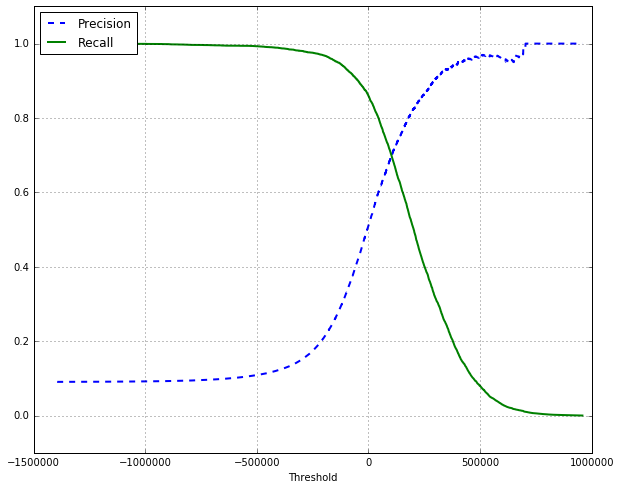

In [59]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [68]:
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(10,8))
    plt.plot(recalls[:-1], precisions[:-1], "b-", linewidth=2)
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="upper left")
    plt.ylim([-0.1, 1.1])
    plt.grid(True, which='major')

C:\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


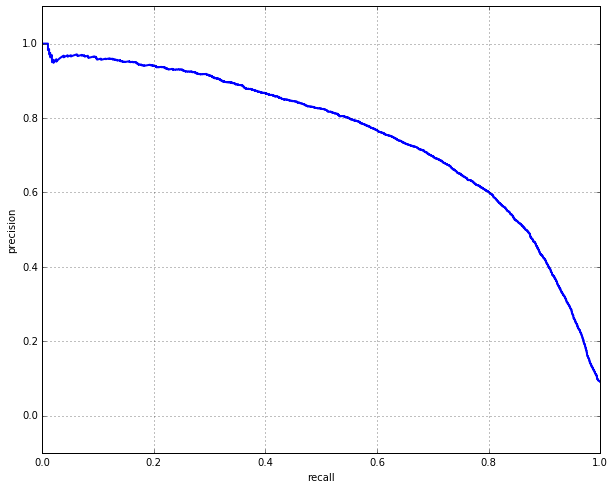

In [69]:
plot_precision_vs_recall(precisions, recalls)
plt.show()

You can see that precision really starts to fall sharply around 80% recall. You will probably want to
select a precision/recall tradeoff just before that drop — for example, at around 60% recall. But of
course the choice depends on your project.  
let’s suppose you decide to aim for 90% precision. You look up the first plot (zooming in a bit) andfind that you need to use a threshold of about 70,000. To make predictions (on the training set for now),
instead of calling the classifier’s predict() method, you can just run this code:

In [74]:
y_train_pred_90 = (y_pred_scores > 70000)
print("Precision: ", precision_score(y_train_5, y_train_pred_90))
print("Recall: ", recall_score(y_train_5, y_train_pred_90))

Precision:  0.641828428303
Recall:  0.756318022505


### The ROC Curve  
The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers.
It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC
curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the
ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true
negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR
is also called specificity. Hence the ROC curve plots sensitivity (recall) versus `1 – specificity`.

In [76]:
from sklearn.metrics import roc_curve

In [78]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_pred_scores)

In [79]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

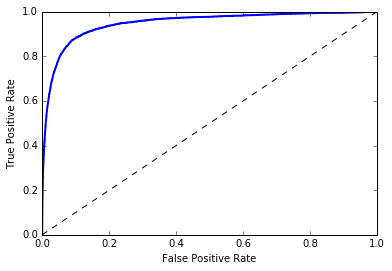

In [80]:
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier
produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays
as far away from that line as possible (toward the top-left corner).  
One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will
have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [81]:
from sklearn.metrics import roc_auc_score

In [82]:
roc_auc_score(y_train_5, y_pred_scores)

0.94791005751225632

Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a
rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false
positives than the false negatives, and the ROC curve otherwise.   

Let's train an another model 

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(random_state=142)